In [27]:
import importlib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as mse

import bbDebiasing as bbDebias
import maxEnsembleDebias as maxDebias
import policies

# Bias Bounties Style Updates

In [41]:
importlib.reload(bbDebias)

xs = np.array([[1],[2],[3]]) 
ys = np.array([[1,10], [2,1], [4,0]])

def h0(xs):
    preds = []
    for x in xs:
        if x==1:
            preds.append([3.,9.])
        if x==2:
            preds.append([1,0])
        if x==3:
            preds.append([1,0])
    return np.array(preds)

def h1(xs):
    preds = []
    for x in xs:
        if x==1:
            preds.append([1.,0.])
        if x==2:
            preds.append([0,1])
        if x==3:
            preds.append([0,1])
    return np.array(preds)

def h2(xs):
    preds = []
    for x in xs:
        if x==1:
            preds.append([0.,1.])
        if x==2:
            preds.append([1,0])
        if x==3:
            preds.append([0,1])
    return np.array(preds)

def h3(xs):
    preds = []
    for x in xs:
        if x==1:
            preds.append([0.,1.])
        if x==2:
            preds.append([0,1])
        if x==3:
            preds.append([1,0])
    return np.array(preds)

max_depth = 20
pred_dim = 2
policy0 = policies.Simplex(pred_dim, h0)
policy1 = policies.Simplex(pred_dim, h1)
policy2 = policies.Simplex(pred_dim, h2)
policy3 = policies.Simplex(pred_dim, h3)
model = bbDebias.bbDebias(max_depth, pred_dim, h0, xs, ys)
model.debias_helper(ys, policy1);
model.debias_helper(ys, policy2);
model.debias_helper(ys, policy3);

all_pi = [policy1, policy2, policy3]
max_depth = 40
tolerance = 1e-3 # after MSE improvement drops below this, halt debiasing process
model = bbDebias.bbDebias(max_depth, pred_dim, h0, xs, ys)

model.debias(ys, all_pi, policy0, max_depth, tolerance)

Hit tolerance; halting debiasing.


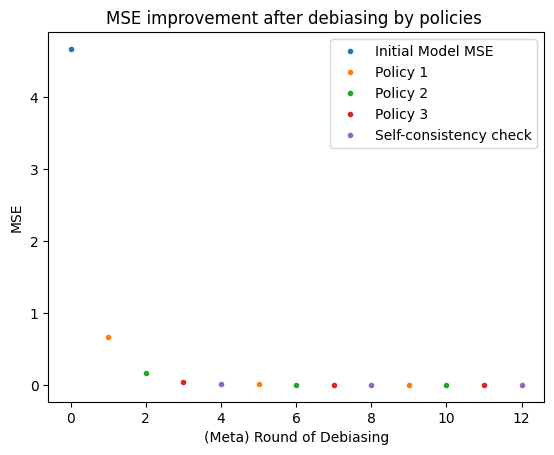

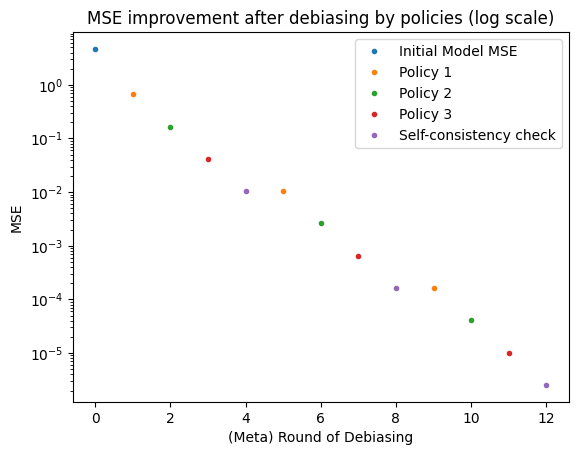

In [43]:
# plot for each type of update independently 

coord = 0
mses = np.array(model.mses_by_policy)
# initial MSE
plt.plot([0], mses[0,coord], '.', label="Initial Model MSE")

# MSE after updating according to policy i
for i in range(1,len(all_pi)+2):
    indices = np.arange(i, len(mses), len(all_pi)+1)
    if i!=len(all_pi)+1:
        plt.plot(indices, mses[indices, coord], '.', label = f"Policy {i}")
    else:
        plt.plot(indices, mses[indices, coord], '.', label = f"Self-consistency check")

plt.xlabel("(Meta) Round of Debiasing")
plt.ylabel("MSE")
plt.title("MSE improvement after debiasing by policies ")
plt.legend()
plt.show()

plt.plot([0], mses[0,coord], '.', label="Initial Model MSE")
for i in range(1,len(all_pi)+2):
    indices = np.arange(i, len(mses), len(all_pi)+1)
    if i!=len(all_pi)+1:
        plt.plot(indices, mses[indices, coord], '.', label = f"Policy {i}")
    else:
        plt.plot(indices, mses[indices, coord], '.', label = f"Self-consistency check")

plt.xlabel("(Meta) Round of Debiasing")
plt.ylabel("MSE")
plt.title("MSE improvement after debiasing by policies (log scale)")
plt.legend()
plt.yscale('log')
plt.show()



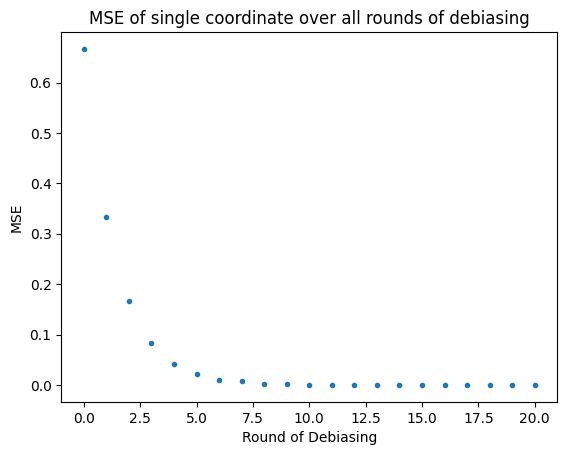

In [44]:
preds = np.array(model.predictions_by_round)
mses = np.zeros((model.curr_depth+1, model.prediction_dim))
for i in range(len(model.predictions_by_round)):
    mses[i] = mse(ys, model.predictions_by_round[i], multioutput='raw_values')

coord = 1
plt.plot(np.arange(model.curr_depth+1), mses[:,coord], '.')
plt.title("MSE of single coordinate over all rounds of debiasing")
plt.xlabel("Round of Debiasing")
plt.ylabel("MSE");


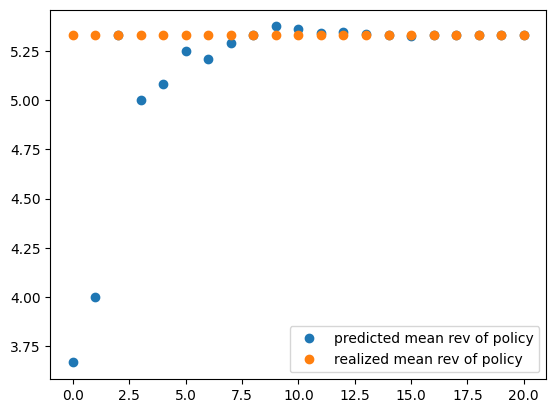

In [45]:
# predicted revenue of each point per round
pred_rev = [np.einsum('ij,ij->i', model.predictions_by_round[i], policy0.run_given_preds(model.predictions_by_round[i])) for i in range(len(model.predictions_by_round))] #fancy vectorized row-wise dot product 
# realized revenue
true_rev = [np.einsum('ij,ij->i', ys, policy0.run_given_preds(model.predictions_by_round[i])) for i in range(len(model.predictions_by_round))]


plt.plot(range(len(model.predictions_by_round)), np.mean(pred_rev, axis=1), 'o', label="predicted mean rev of policy")
plt.plot(range(len(model.predictions_by_round)), np.mean(true_rev, axis=1), 'o', label="realized mean rev of policy")
#plt.axhline(np.mean(np.einsum('ij,ij->i', ys, policy0.run_given_preds(ys))), label="optimal policy mean revenue", color="orange")
plt.legend()

# Max Ensemble Approach

In [50]:
importlib.reload(maxDebias)
importlib.reload(policies)

xs = np.array([[1],[2],[3]]) 
ys = np.array([[1,10], [2,1], [4,0]])

def h0(xs):
    preds = []
    for x in xs:
        if x==1:
            preds.append([3.,9.])
        if x==2:
            preds.append([1,0])
        if x==3:
            preds.append([1,0])
    return np.array(preds)

def h1(xs):
    preds = []
    for x in xs:
        if x==1:
            preds.append([1.,0.])
        if x==2:
            preds.append([0,10])
        if x==3:
            preds.append([0,2])
    return np.array(preds)

policy0 = policies.Simplex(pred_dim, h0)
policy1 = policies.Simplex(pred_dim, h1)

model = maxDebias.EnsembledModel([h0,h1], [policy0, policy1], xs, ys, 3)
model.debias()
out, transcript = model.predict(xs)


In [51]:
transcript

[array([[[ 3.,  9.],
         [ 1.,  0.],
         [ 1.,  0.]],
 
        [[ 1.,  0.],
         [ 0., 10.],
         [ 0.,  2.]]]),
 array([[[ 3. ,  9. ],
         [ 3. ,  0.5],
         [ 3. ,  0.5]],
 
        [[ 1. ,  0. ],
         [ 0. , 10. ],
         [ 0. ,  2. ]]]),
 array([[[ 3. ,  9. ],
         [ 3. ,  0.5],
         [ 3. ,  0.5]],
 
        [[ 1. , 10. ],
         [ 0. , 10. ],
         [ 0. ,  2. ]]]),
 array([[[ 1. , 10. ],
         [ 3. ,  0.5],
         [ 3. ,  0.5]],
 
        [[ 1. , 10. ],
         [ 0. , 10. ],
         [ 0. ,  2. ]]])]